In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import sys
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
print('SYSTEM Version: ', sys.version)
print('PyTorch Version: ', torch.__version__)
# print('Torchvision Version: ', torchvision.__version__)
print('Numpy Version: ', np.__version__)
print('Pandas Version: ', pd.__version__)

SYSTEM Version:  3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
PyTorch Version:  2.1.2
Numpy Version:  1.26.4
Pandas Version:  2.2.1


# Pytorch Dataset
import data

In [3]:
data_dir = '/kaggle/input/cards-image-datasetclassification/train'


In [4]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
    

In [5]:
dataset = PlayingCardDataset(
    data_dir = '/kaggle/input/cards-image-datasetclassification/train'
)

In [6]:
len(dataset)

7624

In [7]:
image, label = dataset[6000]
print(label)
type(image)

41


PIL.Image.Image

In [8]:
target_to_class =  {v: k for k,v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [9]:
transform = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.ToTensor(),
])
dataset = PlayingCardDataset(data_dir, transform)

In [10]:
image, label = dataset[100]
print(label)
image.shape

0


torch.Size([3, 128, 128])

In [11]:
for image, label in dataset:
    break

# DataLoader

In [12]:
dataloader = DataLoader( dataset, batch_size=32, shuffle=True)

In [13]:
for images, labels in dataloader:
    break

In [14]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

# Create a PyTorch Model

we use a structure from timm

In [15]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes = 53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280
        
        self.classifier = nn.Linear(enet_out_size, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [16]:
timm.models

<module 'timm.models' from '/opt/conda/lib/python3.10/site-packages/timm/models/__init__.py'>

In [17]:
model = SimpleCardClassifier(num_classes=53)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [18]:
print(str(model)[:400])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
     


In [19]:
example = model(images)
example.shape # Torch -> [batch_size, num_classes]

torch.Size([32, 53])

# Training the model

## Setup Datasets

In [20]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
train_folder = '/kaggle/input/cards-image-datasetclassification/train'
train_dataset = PlayingCardDataset(train_folder, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_folder = '/kaggle/input/cards-image-datasetclassification/test'
test_dataset = PlayingCardDataset(test_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

valid_folder = '/kaggle/input/cards-image-datasetclassification/valid'
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [22]:
num_epochs = 5
train_losses, valid_losses = [], []

model = SimpleCardClassifier(num_classes = 53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='train loop'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='valid loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    valid_loss = running_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    print(f'Epoch {epoch +1}/{num_epochs} - Train loss: {train_loss}, Valid loss: {valid_loss}  ')

train loop:   0%|          | 0/239 [00:00<?, ?it/s]

valid loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5436299262492128, Valid loss: 0.35274805662766945  


train loop:   0%|          | 0/239 [00:00<?, ?it/s]

valid loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5452888125450138, Valid loss: 0.19355960364611643  


train loop:   0%|          | 0/239 [00:00<?, ?it/s]

valid loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.36766750921357466, Valid loss: 0.16676163336016098  


train loop:   0%|          | 0/239 [00:00<?, ?it/s]

valid loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.22827961060520485, Valid loss: 0.15702052999217556  


train loop:   0%|          | 0/239 [00:00<?, ?it/s]

valid loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.17830727105923114, Valid loss: 0.1084219072224959  


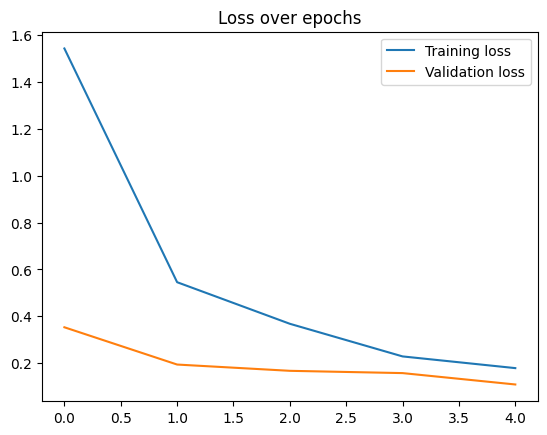

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

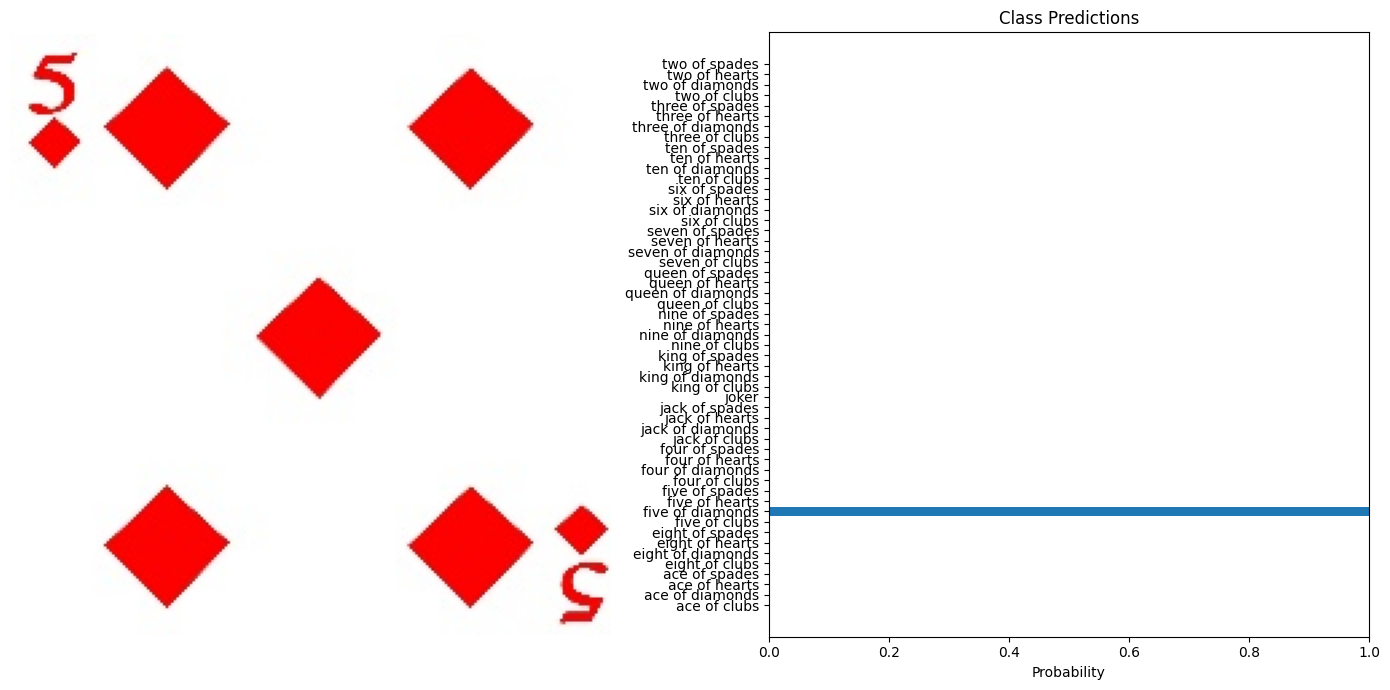

In [24]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.data.classes 
visualize_predictions(original_image, probabilities, class_names)